## Примеры реализации и сравнение методов безусловной оптимизации

Рассмотрим различные методы выбора шага:

In [1]:
def alpha_Armijo_rule(x, f, grad_f_x, h, alpha, gamma, theta):
    x = np.array(x)
    h = np.array(h)
    alpha_ = alpha 
    while f(x + alpha_ * h) - f(x) > gamma * alpha_ * (grad_f_x * h).sum():
        alpha_*= theta
    return alpha_    

In [2]:
def alpha_constant(x, f, grad_f_x, h, alpha, gamma, theta):
    return alpha

Функция для построения графиков

In [3]:
def add_graph(x, y, label, ymin, ymax):
    plt.plot(x, y, '-o' ,label=label)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()

In [4]:
%matplotlib inline
import pylab
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from scipy import integrate
import numpy.linalg as ln
import scipy as sp
import scipy.optimize
import math
matplotlib.rcParams.update({'font.size': 22})
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

## Квази-Ньютоновский метод BFGS

Рассмотрим функцию $f = x \cdot (ln(x+1))$

Result of BFGS method with constant:
Final Result (best point): [ 1.49805092e-06 -3.00206750e-06]
Iteration Count: 7


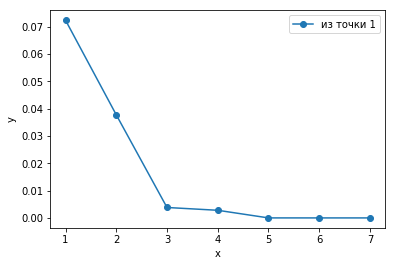

Result of BFGS method with Armijo:
Final Result (best point): [-1.44575116e-05 -2.86001824e-05]
Iteration Count: 5


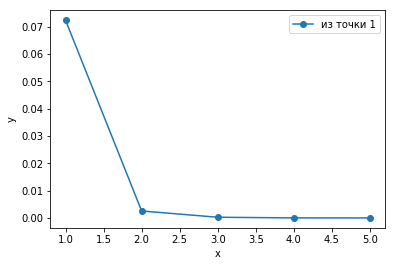

In [5]:

def f1(x):
    res = np.zeros(len(x))
    for i in range(len(res)):
        res[i] = np.log(x[i]+1) + x[i]*(1 / (x[i] + 1))
    return res


f = lambda x: sum(x*np.log(x+1))



def bfgs_method(f, fprime, x0, rule, alpha_0, epsi=10e-3, gamma = 0.2, theta = 0.5):    
    maxiter = len(x0) * 200
    # initial values
    k = 0
    gfk = fprime(x0)
    N = len(x0)
    # Set the Identity matrix I.
    I = np.eye(N, dtype=int)
    Hk = I
    xk = x0
    answer = []
    while ln.norm(gfk) > epsi and k < maxiter:
        
        
        pk = -np.dot(Hk, gfk)
        #line_search = sp.optimize.line_search(f, f1, xk, pk)

        alpha_k = alpha_0
        alpha_k = rule(xk, f, gfk, pk , alpha_k, gamma, theta)

        xkp1 = xk + alpha_k * pk
        sk = xkp1 - xk
        xk = xkp1
        
        gfkp1 = fprime(xkp1)
        yk = gfkp1 - gfk
        gfk = gfkp1
        
        k += 1
        
        ro = 1.0 / (np.dot(yk, sk))
        A1 = I - ro * sk[:, np.newaxis] * yk[np.newaxis, :]
        A2 = I - ro * yk[:, np.newaxis] * sk[np.newaxis, :]
        Hk = np.dot(A1, np.dot(Hk, A2)) + (ro * sk[:, np.newaxis] *
                                                 sk[np.newaxis, :])
        answer.append((xk, k))
        

    return answer


#result, k = bfgs_method(f, f1, np.ones(10))
x0 = np.random.randint(0, 25, 2)
answer = bfgs_method(f, f1, x0/10, alpha_constant, 1, 10e-5)
result, k = answer[-1]

print('Result of BFGS method with constant:')
print('Final Result (best point): %s' % (result))
print('Iteration Count: %s' % (k))
temp = np.array(answer)
sett = [f(temp[i][0] ) for i in range(len(temp[:,0]))]
add_graph(temp[:,1], sett, "из точки 1", ymin=0, ymax=0.8)
plt.show()

answer = bfgs_method(f, f1, x0/10,  alpha_Armijo_rule, 1, 10e-5)
result, k = answer[-1]

print('Result of BFGS method with Armijo:')
print('Final Result (best point): %s' % (result))
print('Iteration Count: %s' % (k))
temp = np.array(answer)
sett = [f(temp[i][0] ) for i in range(len(temp[:,0]))]
add_graph(temp[:,1], sett, "из точки 1", ymin=0, ymax=0.8)
plt.show()

In [6]:
def hessf(x):
    res = np.zeros((len(x),len(x)))
    for i in range(len(x)):
        for j in range(len(x)):
            if (i == j):
                res[i] = 2/(x[i]+1) - (x[i] / (x[i]+1)**2)
        res[i] = np.log(x[i]+1) + x[i]*(1 / (x[i] + 1))
    return res

In [7]:
epsilon = 0.00001
max_c = 2000

In [8]:
def norm(x):
    x = np.array(x)
    return ((x**2).sum())**0.5

In [9]:
def gradient_descent(iteration_num_left, x_prev, f, grad, alpha, alpha_0, gamma = 0.2, theta = 0.5):
    grad_x_prev = grad(x_prev)
    a = alpha(x_prev,f, grad_x_prev, np.zeros(np.size(grad_x_prev)) - grad_x_prev, alpha_0, gamma, theta)
    x = x_prev - a * grad_x_prev
    
    if norm(x) > max_c or norm(grad(x_prev)) < epsilon or norm(x - x_prev) < 2 * epsilon or iteration_num_left == 0:
        return x
    
    return gradient_descent(iteration_num_left - 1, x, f, grad, alpha, alpha_0, gamma, theta)    

In [10]:
def Newton(f, gradf, hessf, x0, epsilon, num_iter, rule, alpha_0, gamma = 0.2, theta = 0.5):
    x = x0.copy()
    iteration = 0
    answer = []
    while True:
        gradient = gradf(x)
        hess = hessf(x)
        h = np.linalg.solve(hess, -gradient)
        alpha = alpha_0
        #alpha = rule(x, f, gradient, h , alpha, gamma, theta)
        alpha = alpha_Armijo_rule(x, f, gradient, h , alpha, gamma, theta)
        x = x + alpha * h
        answer.append((x, iteration))
        iteration += 1
        if np.linalg.norm(gradf(x)) < epsilon:
            break
        if iteration >= num_iter:
            break
        
    #res = {"x": x, "num_iter": iteration, "tol": np.linalg.norm(gradf(x))}
    return answer

In [11]:
def f_4(x):
    return 100*(x[1] - x[0]**2)**2 + (1-x[0])**2
def grad_f_4(x):
    return np.array((-400*x[0]*(x[1] - x[0]**2) - 2*(1 - x[0]), 200*(x[1] - x[0]**2)))
def inv_grad_grad_f_4(x):
    return 1/(-400*200*(x[1]-x[0]**2)+2) *  np.array(
        [200, 400*x[0], 400*x[0], -400*(x[1]-3*x[0]) + 2]).reshape((2,2))
def grad_f_4(x):
    res = np.zeros(len(x))
    for i in range(len(res)):
        res[i] = np.log(x[i]+1) + x[i]*(1 / (x[i] + 1))
    return res

f_4 = lambda x: sum(x*np.log(x+1))

def inv_grad_grad_f_4(x):
    res = np.zeros((len(x),len(x)))
    for i in range(len(x)):
        for j in range(len(x)):
            if (i == j):
                res[i][j] = 2/(x[i]+1) - (x[i] / (x[i]+1)**2)
    return res



Result of BFGS method with constant:
Final Result (best point): [0.00315613 0.00339672]
Iteration Count: 25


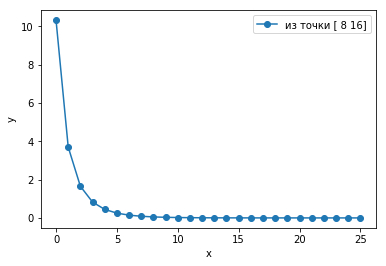

Result of BFGS method with Armijo:
Final Result (best point): [0.00315613 0.00339672]
Iteration Count: 25


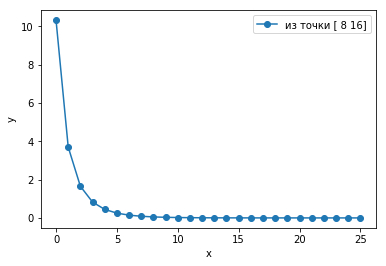

In [12]:
x0 = np.random.randint(0, 25, 2)
answer = Newton(f_4, grad_f_4, inv_grad_grad_f_4, x0, 10e-3,1000, alpha_constant, 0.2)
result, k = answer[-1]
print('Result of BFGS method with constant:')
print('Final Result (best point): %s' % (result))
print('Iteration Count: %s' % (k))
temp = np.array(answer)
sett = [f(temp[i][0] ) for i in range(len(temp[:,0]))]
add_graph(temp[:,1], sett, "из точки "+str(x0), ymin=0, ymax=0.8)
plt.show()

answer = Newton(f_4, grad_f_4, inv_grad_grad_f_4, x0, 10e-3,1000, alpha_Armijo_rule, 0.2)
result, k = answer[-1]
print('Result of BFGS method with Armijo:')
print('Final Result (best point): %s' % (result))
print('Iteration Count: %s' % (k))
temp = np.array(answer)
sett = [f(temp[i][0] ) for i in range(len(temp[:,0]))]
add_graph(temp[:,1], sett, "из точки "+str(x0), ymin=0, ymax=0.8)
plt.show()